# Trends Analysis Visualization (piControl, Historical, LMR, SSPs)

In [1]:
%reload_ext autoreload
%autoreload 2
import pens
from pens.utils import means_and_trends_ensemble #this may not be available for public use yet.
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
from scipy.stats import gaussian_kde

plt.style.use('default')
pens.set_style()

## Load CMIP6 data
##### Using [Paleobook](https://linked.earth/LMR_CMIP_paleobook/README.html) to process and extract the simulations, the data being used here was aggregated from every lab that ran both piControl and Hitorical CMIP6 simulations. 

### historical runs

(<Figure size 1000x400 with 1 Axes>,
 <Axes: title={'center': 'CMIP6 HIST'}, xlabel='Year', ylabel='GMST anomaly [${}^\\circ$K]'>)

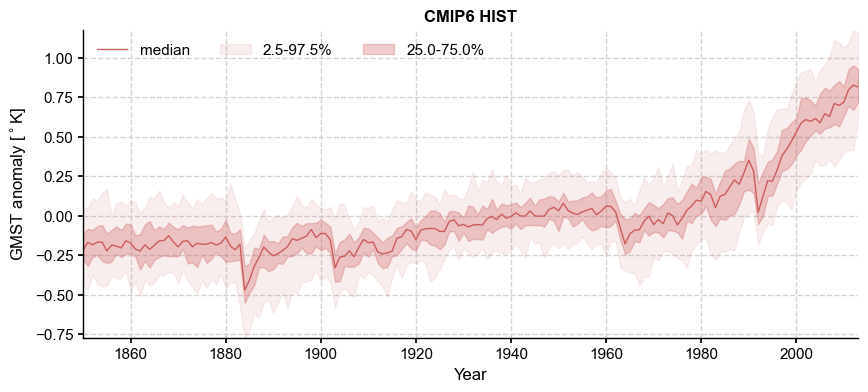

In [2]:
ensemble_data = []
time = None

dir = '../historical_NetCDF'
files = os.listdir(dir)

for file in files:
    file_path = os.path.join(dir, file)
    ds = xr.open_dataset(file_path)
    
    if len(ds['time']) > 164:
        ds = ds.isel(time=slice(0, 164))
    
    if time is None:
        # Convert the time values to integers (years)
        time_values = np.array([int(t.dt.year) for t in ds['time']])
        time = time_values
    
    # Extract the GMST anomaly values
    gmst_anomaly_values = ds['tas'].values.squeeze()
    
    ensemble_data.append(gmst_anomaly_values)

# Concatenate the GMST anomaly values along the member dimension (axis=1)
ensemble_data = np.column_stack(ensemble_data)

# Create the EnsembleTS object
cmip6_hist_ensemble = pens.EnsembleTS(time=time, time_name='Year', label='CMIP6 HIST',
                                      value=ensemble_data, value_name='GMST anomaly',
                                      value_unit=r'${}^\circ$K')

cmip6_hist_ensemble.plot_qs()


## Lets see piControl 
##### Loading the data from the locally downloaded netCDF files, switching the item data into integers is needed to properly plot the KDEs. Because piControl time axes vary, we have to make some new code since the EnsembleTS objects from the pens library assume that every ensemble shares the same time axes length.

##### *Note: I am not sharing the data to the repositorty for now, + the other shared notebook provides a tutorial with how to download the data.

In [3]:
pi_files = {}

dir = '../picontrol_NetCDF'
files = os.listdir(dir)

for file in files:
    file_path = os.path.join(dir, file)
    ds = xr.open_dataset(file_path)

    # Convert the time values to integers (years)
    time_values = ds['time'].dt.year.astype(int)
    ds = ds.assign_coords(time = time_values)
    pi_files[os.path.basename(file_path)] = ds
    


/Applications/anaconda3/envs/conda-env-paleobook-dev-py/lib/python3.10/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Applications/anaconda3/envs/conda-env-paleobook-dev-py/lib/python3.10/site-packages/xarray/core/indexing.py:557: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()
/Applications/anaconda3/envs/conda-env-paleobook-dev-py/lib/python3.10/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.u

/Applications/anaconda3/envs/conda-env-paleobook-dev-py/lib/python3.10/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Applications/anaconda3/envs/conda-env-paleobook-dev-py/lib/python3.10/site-packages/xarray/core/indexing.py:557: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()
/Applications/anaconda3/envs/conda-env-paleobook-dev-py/lib/python3.10/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.u

/Applications/anaconda3/envs/conda-env-paleobook-dev-py/lib/python3.10/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Applications/anaconda3/envs/conda-env-paleobook-dev-py/lib/python3.10/site-packages/xarray/core/indexing.py:557: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()
/Applications/anaconda3/envs/conda-env-paleobook-dev-py/lib/python3.10/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.u

##### Now I convert each picontrol file into a numpy array and apply the means and trends ensemble method from pens to get the means ands trends data returned. I then add them in a nested dictionary directory which I will be using below.

In [4]:
for key in pi_files.keys():
    file = pi_files[key]
    time = file['time'].values
    gmst = file['tas'].values
    var = np.expand_dims(gmst, axis=1)  # Add an extra dimension to represent a single ensemble member
    x = means_and_trends_ensemble(var, 10, 10, time)
    temp = {}
    temp['means'] = x[0]
    temp['trends'] = x[1]
    pi_files[key] = temp


Processing member: 100%|████████████████████████| 1/1 [00:00<00:00, 31.80it/s]


#### Below is a test to visualize all of the Means KDEs

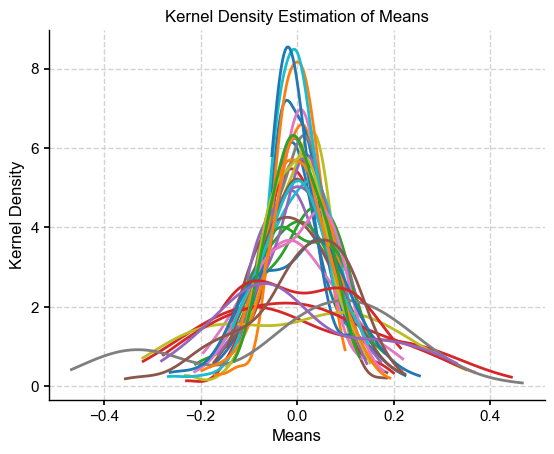

In [264]:
from scipy.stats import gaussian_kde

# Initialize the plot
plt.figure()

# Iterate over the keys and plot the KDE of means
for key in pi_files.keys():
    means = pi_files[key]['means'][:, 0]  # Access the first column and flatten the array
    # Extract a substring from the key name
    label = '.'.join(key.split('.')[1:3])

    # Estimate the kernel density of the means
    kde = gaussian_kde(means)

    # Generate a range of values to evaluate the KDE
    x = np.linspace(np.min(means), np.max(means), 100)

    # Plot the KDE
    plt.plot(x, kde(x), label=label)

# Set labels and title
plt.xlabel('Means')
plt.ylabel('Kernel Density')
plt.title('Kernel Density Estimation of Means')

# Add legend
# plt.legend() #if you want to see all of the file tags

# Show the plot
plt.show()

#### Below is a test of all of the trends KDEs

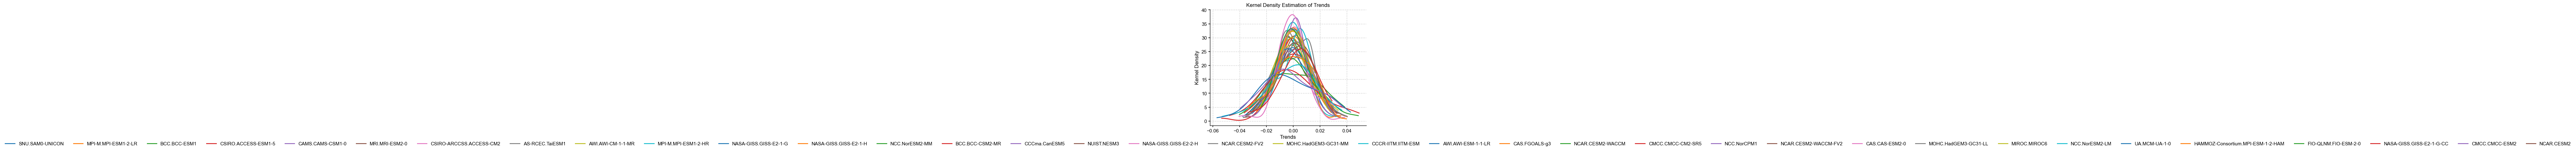

In [237]:
from scipy.stats import gaussian_kde

# Initialize the plot
plt.figure()

# Iterate over the keys and plot the KDE of means
for key in pi_files.keys():
    trends = pi_files[key]['trends'][:, 0]  # Access the first column and flatten the array
    # Extract a substring from the key name
    label = '.'.join(key.split('.')[1:3])

    # Estimate the kernel density of the means
    kde = gaussian_kde(trends, bw_method='silverman')

    # Generate a range of values to evaluate the KDE
    x = np.linspace(np.min(trends), np.max(trends), 100)

    # Plot the KDE
    plt.plot(x, kde(x), label=label)

# Set labels and title
plt.xlabel('Trends')
plt.ylabel('Kernel Density')
plt.title('Kernel Density Estimation of Trends')

# Add legend
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=len(pi_files))

# Show the plot
plt.show()

## Concatinating piControl simulations - time to make them *pretty*
##### the next step is to concatinate the data into a single, homogenized array. After that, apply kde and plot

In [233]:
picontrol_means = np.concatenate([pi_files[key]['means'][:, 0] for key in pi_files.keys()])

# Calculate the average KDE
picontrol_kde = gaussian_kde(picontrol_means, bw_method='silverman')

# Generate a range of values to evaluate the KDE
x = np.linspace(np.min(picontrol_means), np.max(picontrol_means), 100)

# Evaluate the KDE at the x values
y = picontrol_kde(x)

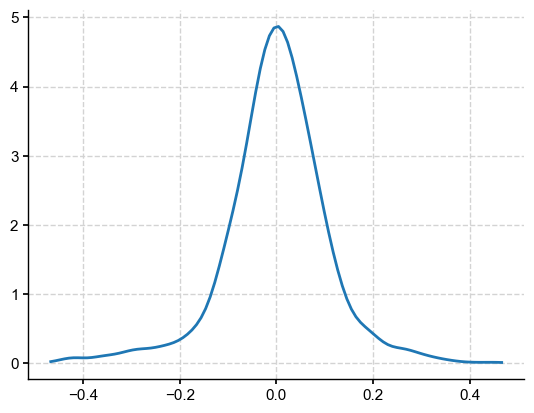

In [234]:
plt.plot(x, y, label='cmip6 picontrol means')

In [265]:
picontrol_trends = np.concatenate([pi_files[key]['trends'][:, 0] for key in pi_files.keys()])

# Calculate the average KDE
picontrol_kde = gaussian_kde(picontrol_trends, bw_method='silverman')

# Generate a range of values to evaluate the KDE
x = np.linspace(np.min(picontrol_trends), np.max(picontrol_trends), 100)

# Evaluate the KDE at the x values
y = picontrol_kde(x)

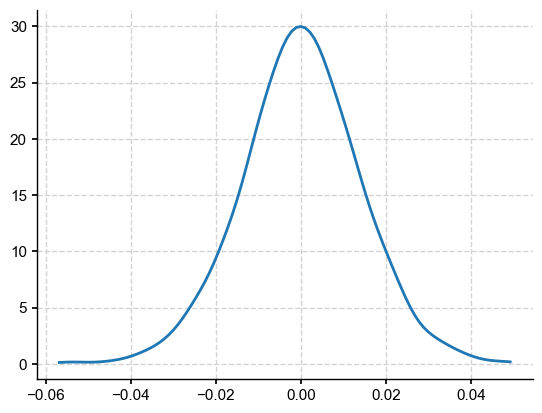

In [266]:
plt.plot(x, y, label='cmip6 picontrol trends')

#### Upon plotting the piControl trends on the final plot, it came out a little wonky as applying a KDE on what is essentially a delta function isn't appropriate. Instead, let's create a 'band' to represent the piControl trends plot which makes for a better visualizaiton. 

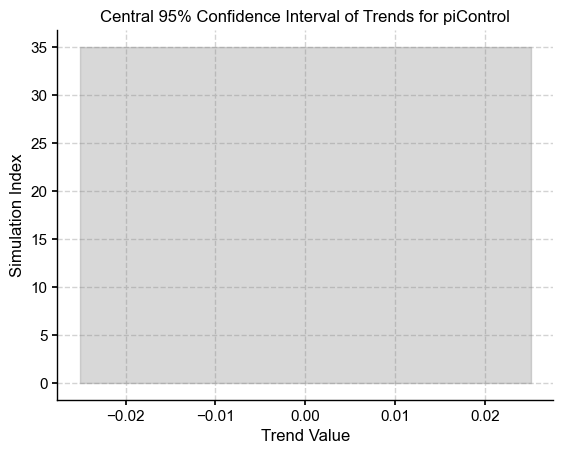

In [258]:
# Initialize the plot
plt.figure()

# Create empty arrays to store lower and upper bounds
lower_bounds = []
upper_bounds = []

# Iterate over the keys and compute the quantiles
for key in pi_files.keys():
    trends_data = pi_files[key]['trends'][:, 0]  # Access the first column and flatten the array
    
    # Calculate the quantiles
    lower_bound = np.percentile(trends_data, 2.5)
    upper_bound = np.percentile(trends_data, 97.5)
    
    # Append the bounds to the arrays
    lower_bounds.append(lower_bound)
    upper_bounds.append(upper_bound)

# Calculate the mean lower and upper bounds
mean_lower_bound = np.mean(lower_bounds)
mean_upper_bound = np.mean(upper_bounds)

# Create an array of y-values (use np.arange for simplicity)
y_values = np.arange(len(pi_files))

# Plot the 95% confidence interval using fill_betweenx
plt.fill_betweenx(y_values, mean_lower_bound, mean_upper_bound, color='grey', alpha=0.3)

plt.title('Central 95% Confidence Interval of Trends for piControl')
plt.xlabel('Trend Value')
plt.ylabel('Simulation Index')

# Show the plot
plt.show()
# -NOTE- to scale of course with the other plots this wil look like a vertical band

## kde helper functions for piControl
##### because the KDEs will be generated for every resepctive block size, I put the above code into functions to make the process more efficient.

In [4]:
def picontrol_means_and_trends(block, step, data_dict):
    output = {}
    for key in data_dict.keys():
        file = data_dict[key]
        time = file['time'].values
        gmst = file['tas'].values
        var = np.expand_dims(gmst, axis=1)  # Add an extra dimension to represent a single ensemble member
        x = means_and_trends_ensemble(var, block, step, time)
        temp = {}
        temp['means'] = x[0]
        temp['trends'] = x[1]
        output[key] = temp
    return output #ouputs a dictionary


In [5]:
def picontrol_kdes(numpoints, dict):

    output = []
    
    # means first
    means = []
    picontrol_means = np.concatenate([dict[key]['means'][:, 0] for key in dict.keys()])
    means_kde = gaussian_kde(picontrol_means, bw_method='silverman')
    x = np.linspace(np.min(picontrol_means), np.max(picontrol_means), numpoints)
    y = means_kde(x)
    means.append(x)
    means.append(y)

    # now trends
    trends = []
    picontrol_trends = np.concatenate([dict[key]['trends'][:, 0] for key in dict.keys()])
    trends_kde = gaussian_kde(picontrol_trends, bw_method='silverman')
    x = np.linspace(np.min(picontrol_trends), np.max(picontrol_trends), numpoints)
    y = trends_kde(x)
    trends.append(x)
    trends.append(y)

    # Store the KDEs in the 'output' list
    output.append(means)
    output.append(trends)

    return output #outputs a 2D array

## Loading the LMR Data
##### lazy load LMR from pangeo forge 

In [6]:
store = "https://ncsa.osn.xsede.org/Pangeo/pangeo-forge/test/pangeo-forge/staged-recipes/recipe-run-1409/LMRv2p1_MCruns_ensemble_ungridded.zarr"
lmr_ds_ungridded = xr.open_dataset(store, engine='zarr', chunks={}, decode_times=False)
lmr_ds_ungridded

<xarray.Dataset>
Dimensions:              (time: 2001, MCrun: 20, members: 100, lat: 24, lon: 81)
Coordinates:
  * lat                  (lat) float32 20.0 22.0 24.0 26.0 ... 62.0 64.0 66.0
  * lon                  (lon) float32 100.0 102.0 104.0 ... 256.0 258.0 260.0
  * time                 (time) int64 0 365 730 1095 ... 729270 729635 730000
Dimensions without coordinates: MCrun, members
Data variables:
    amo                  (time, MCrun, members) float32 dask.array<chunksize=(1, 20, 100), meta=np.ndarray>
    ao                   (time, MCrun, members) float32 dask.array<chunksize=(1, 20, 100), meta=np.ndarray>
    ensmean_pdo_idx      (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    ensmean_pdo_pattern  (lat, lon) float32 dask.array<chunksize=(24, 81), meta=np.ndarray>
    gmt                  (time, MCrun, members) float32 dask.array<chunksize=(1, 20, 100), meta=np.ndarray>
    nao                  (time, MCrun, members) float32 dask.array<chunksize=(1, 20, 100), meta=np.ndarray>
    nhmt                 (time, MCrun, members) float32 dask.array<chunksize=(1, 20, 100), meta=np.ndarray>
    nino34               (time, MCrun, members) float32 dask.array<chunksize=(1, 20, 100), meta=np.ndarray>
    pdo                  (time, MCrun, members) float32 dask.array<chunksize=(1, 20, 100), meta=np.ndarray>
    sam                  (time, MCrun, members) float32 dask.array<chunksize=(1, 20, 100), meta=np.ndarray>
    shmt                 (time, MCrun, members) float32 dask.array<chunksize=(1, 20, 100), meta=np.ndarray>
    soi                  (time, MCrun, members) float32 dask.array<chunksize=(1, 20, 100), meta=np.ndarray>
Attributes:
    comment:                   File contains full ensemble values for each Mo...
    description:               Last Millennium Reanalysis climate field recon...
    experiment:                productionFinal2_gisgpcc_ccms4_LMRdbv1.1.0_tas
    pangeo-forge:inputs_hash:  51192b3d1b2a5bf9297cd3e6d03e1f98e202d6571545d5...
    pangeo-forge:recipe_hash:  c41d1ef8f142f43547e95f9e75160849d7554e2afaad4e...
    pangeo-forge:version:      0.9.2

In [7]:
gmt_arr = lmr_ds_ungridded.gmt.to_numpy().reshape((2001, 20*100))
time = lmr_ds_ungridded.time.values/365


(<Figure size 1000x400 with 1 Axes>,
 <Axes: title={'center': 'LMRv2.1'}, xlabel='time', ylabel='GMT [${}^\\circ C$]'>)

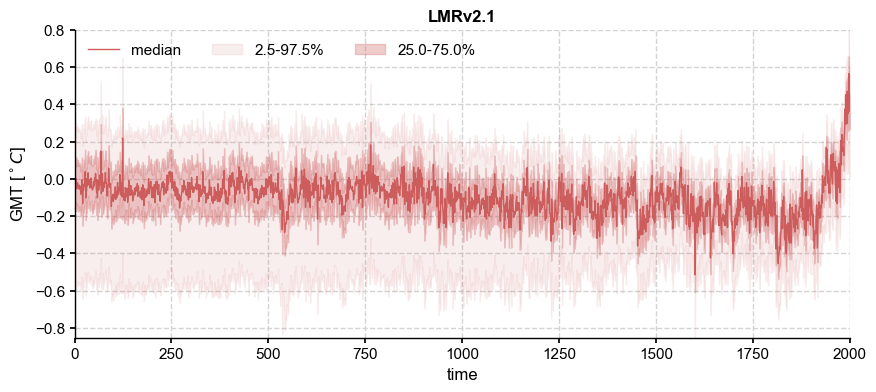

In [25]:
gmt = pens.EnsembleTS(time = time, label = 'LMRv2.1',
                      value = gmt_arr, value_name = 'GMT', value_unit = r'${}^\circ C$')
gmt.plot_qs()

## Making a plot based on block size
##### now that we have all of the picontrol/historical estimations running, let's plot the means and trends on two different graphs.

In [11]:
hist_trends_10 = cmip6_hist_ensemble.get_trend(segment_length=10, step=5, xm=np.linspace(-1, 5, 200), bw='silverman')
hist_trends_25 = cmip6_hist_ensemble.get_trend(segment_length=25, step=10, xm=np.linspace(-1, 5, 200), bw='silverman')
hist_trends_50 = cmip6_hist_ensemble.get_trend(segment_length=50, step=15, xm=np.linspace(-1, 5, 200), bw='silverman')
hist_trends_75 = cmip6_hist_ensemble.get_trend(segment_length=75, step=5, xm=np.linspace(-1, 5, 200), bw='silverman')

Processing member: 100%|███████████████████████| 34/34 [00:00<00:00, 144.24it/s]


dmeans.shape: (30, 34)
dtrends.shape: (30, 34)


Processing member: 100%|███████████████████████| 34/34 [00:00<00:00, 264.32it/s]


dmeans.shape: (13, 34)
dtrends.shape: (13, 34)


Processing member: 100%|███████████████████████| 34/34 [00:00<00:00, 411.40it/s]


dmeans.shape: (7, 34)
dtrends.shape: (7, 34)


Processing member: 100%|███████████████████████| 34/34 [00:00<00:00, 215.20it/s]

dmeans.shape: (17, 34)
dtrends.shape: (17, 34)


In [34]:
%%time
lmr_trends_10 = gmt.get_trend(segment_length=10, step=5, xm=np.linspace(-1, 5, 500), bw = 'silverman')

Processing member: 100%|████████████████████| 2000/2000 [02:32<00:00, 13.11it/s]


dmeans.shape: (398, 2000)
dtrends.shape: (398, 2000)
CPU times: user 2min 31s, sys: 2.84 s, total: 2min 34s
Wall time: 2min 32s


In [35]:
%%time
lmr_trends_25 = gmt.get_trend(segment_length=25, step=5, xm=np.linspace(-1, 5, 500), bw = 'silverman')

Processing member: 100%|████████████████████| 2000/2000 [03:38<00:00,  9.15it/s]

dmeans.shape: (395, 2000)
dtrends.shape: (395, 2000)
CPU times: user 2min 39s, sys: 4.44 s, total: 2min 43s
Wall time: 3min 38s


In [36]:
%%time
lmr_trends_50 = gmt.get_trend(segment_length=50, step=5, xm=np.linspace(-1, 5, 500), bw = 'silverman')

Processing member: 100%|████████████████████| 2000/2000 [02:50<00:00, 11.71it/s]

dmeans.shape: (390, 2000)
dtrends.shape: (390, 2000)
CPU times: user 2min 46s, sys: 3.34 s, total: 2min 49s
Wall time: 2min 50s


In [37]:
%%time
lmr_trends_75 = gmt.get_trend(segment_length=75, step=5, xm=np.linspace(-1, 5, 500), bw = 'silverman')

Processing member: 100%|████████████████████| 2000/2000 [02:55<00:00, 11.38it/s]

dmeans.shape: (385, 2000)
dtrends.shape: (385, 2000)
CPU times: user 2min 51s, sys: 3.85 s, total: 2min 55s
Wall time: 2min 55s


#### time to get means and trends for the SSPs (RCPs), which were grabbed from this repo: 'https://github.com/swartn/cmip6-gmst-anoms'. Each SSP will be turned into an EnsembleTS object.

In [16]:
#SSP 1-2.6

file_path = '../SSP CSVs/cmip6_ssp126_gmst_swartn_gmst_anoms.csv'
df = pd.read_csv(file_path)

# Convert the DataFrame to a 2D NumPy array
numpy_2d_array = df.to_numpy()

numpy_2d_array = np.array([row[2:] for row in numpy_2d_array], dtype=float)

numpy_2d_array = numpy_2d_array[:-1]

ssp126 = pens.EnsembleTS(time=time, time_name='Year', label='SSP 126',
                                      value=numpy_2d_array, value_name='ScenarioMIP',
                                      value_unit=r'${}^\circ$K')

In [17]:
#SSP 2-4.5


file_path = '../SSP CSVs/cmip6_ssp245_gmst_swartn_gmst_anoms.csv'
df = pd.read_csv(file_path)

# Convert the DataFrame to a 2D NumPy array
numpy_2d_array = df.to_numpy()

numpy_2d_array = np.array([row[2:] for row in numpy_2d_array], dtype=float)

numpy_2d_array = numpy_2d_array[:-1]

ssp245 = pens.EnsembleTS(time=time, time_name='Year', label='SSP 245',
                                      value=numpy_2d_array, value_name='ScenarioMIP',
                                      value_unit=r'${}^\circ$K')

##### *note* the 'MPI-ESM-1-2-HAM' and the 'BCC-ESM1' experiments unfortunatley only seem to run to the year 2055 while the rest til' 2100, so I am removing those experiments from SSP370.

In [18]:
#SSP 3-7.0

file_path = '../SSP CSVs/cmip6_ssp370_gmst_swartn_gmst_anoms.csv'
df = pd.read_csv(file_path)

df = df.drop(columns=['BCC-ESM1', 'MPI-ESM-1-2-HAM'])

# Convert the DataFrame to a 2D NumPy array
numpy_2d_array = df.to_numpy()

numpy_2d_array = np.array([row[2:] for row in numpy_2d_array], dtype=float)

numpy_2d_array = numpy_2d_array[:-1]

ssp370 = pens.EnsembleTS(time=time, time_name='Year', label='SSP 370',
                                      value=numpy_2d_array, value_name='ScenarioMIP',
                                      value_unit=r'${}^\circ$K')

In [19]:
#SSP 5-8.5

file_path = '../SSP CSVs/cmip6_ssp585_gmst_swartn_gmst_anoms.csv'
df = pd.read_csv(file_path)

# Convert the DataFrame to a 2D NumPy array
numpy_2d_array = df.to_numpy()

numpy_2d_array = np.array([row[2:] for row in numpy_2d_array], dtype=float)

numpy_2d_array = numpy_2d_array[:-1]

ssp585 = pens.EnsembleTS(time=time, time_name='Year', label='SSP 585',
                                      value=numpy_2d_array, value_name='ScenarioMIP',
                                      value_unit=r'${}^\circ$K')

#### for ssp126, ssp245, ssp585, year 2100 had missing value so we are just going to remove the last year of data.

In [32]:
ssp126_trends_10 = ssp126.get_trend(segment_length=10, step=5, xm=np.linspace(-1, 5, 500), bw='silverman')
ssp245_trends_10 = ssp245.get_trend(segment_length=10, step=5, xm=np.linspace(-1, 5, 500), bw='silverman')
ssp370_trends_10 = ssp370.get_trend(segment_length=10, step=5, xm=np.linspace(-1, 5, 500), bw='silverman')
ssp585_trends_10 = ssp585.get_trend(segment_length=10, step=5, xm=np.linspace(-1, 5, 500), bw='silverman')

ssp126_trends_25 = ssp126.get_trend(segment_length=25, step=10, xm=np.linspace(-2, 5, 500), bw='silverman')
ssp245_trends_25 = ssp245.get_trend(segment_length=25, step=10, xm=np.linspace(-2, 5, 500), bw='silverman')
ssp370_trends_25 = ssp370.get_trend(segment_length=25, step=10, xm=np.linspace(-2, 5, 500), bw='silverman')
ssp585_trends_25 = ssp585.get_trend(segment_length=25, step=10, xm=np.linspace(-2, 5, 500), bw='silverman')

ssp126_trends_50 = ssp126.get_trend(segment_length=50, step=15, xm=np.linspace(-2, 5, 500), bw='silverman')
ssp245_trends_50 = ssp245.get_trend(segment_length=50, step=15, xm=np.linspace(-2, 5, 500), bw='silverman')
ssp370_trends_50 = ssp370.get_trend(segment_length=50, step=15, xm=np.linspace(-2, 5, 500), bw='silverman')
ssp585_trends_50 = ssp585.get_trend(segment_length=50, step=15, xm=np.linspace(-2, 5, 500), bw='silverman')

ssp126_trends_75 = ssp126.get_trend(segment_length=75, step=5, xm=np.linspace(-1, 5, 500), bw='silverman')
ssp245_trends_75 = ssp245.get_trend(segment_length=75, step=5, xm=np.linspace(-1, 5, 500), bw='silverman')
ssp370_trends_75 = ssp370.get_trend(segment_length=75, step=5, xm=np.linspace(-1, 5, 500), bw='silverman')
ssp585_trends_75 = ssp585.get_trend(segment_length=75, step=5, xm=np.linspace(-1, 5, 500), bw='silverman')

Processing member: 100%|███████████████████████| 17/17 [00:00<00:00, 260.90it/s]


dmeans.shape: (15, 17)
dtrends.shape: (15, 17)


Processing member: 100%|███████████████████████| 17/17 [00:00<00:00, 232.42it/s]


dmeans.shape: (15, 17)
dtrends.shape: (15, 17)


Processing member: 100%|███████████████████████| 15/15 [00:00<00:00, 241.86it/s]


dmeans.shape: (15, 15)
dtrends.shape: (15, 15)


Processing member: 100%|███████████████████████| 17/17 [00:00<00:00, 248.75it/s]


dmeans.shape: (15, 17)
dtrends.shape: (15, 17)


Processing member: 100%|███████████████████████| 17/17 [00:00<00:00, 405.96it/s]


dmeans.shape: (6, 17)
dtrends.shape: (6, 17)


Processing member: 100%|███████████████████████| 17/17 [00:00<00:00, 427.67it/s]


dmeans.shape: (6, 17)
dtrends.shape: (6, 17)


Processing member: 100%|███████████████████████| 15/15 [00:00<00:00, 415.96it/s]


dmeans.shape: (6, 15)
dtrends.shape: (6, 15)


Processing member: 100%|███████████████████████| 17/17 [00:00<00:00, 397.64it/s]


dmeans.shape: (6, 17)
dtrends.shape: (6, 17)


Processing member: 100%|███████████████████████| 17/17 [00:00<00:00, 694.81it/s]


dmeans.shape: (2, 17)
dtrends.shape: (2, 17)


Processing member: 100%|███████████████████████| 17/17 [00:00<00:00, 690.92it/s]


dmeans.shape: (2, 17)
dtrends.shape: (2, 17)


Processing member: 100%|███████████████████████| 15/15 [00:00<00:00, 651.46it/s]


dmeans.shape: (2, 15)
dtrends.shape: (2, 15)


Processing member: 100%|███████████████████████| 17/17 [00:00<00:00, 693.37it/s]


dmeans.shape: (2, 17)
dtrends.shape: (2, 17)


Processing member: 100%|███████████████████████| 17/17 [00:00<00:00, 703.37it/s]


dmeans.shape: (2, 17)
dtrends.shape: (2, 17)


Processing member: 100%|███████████████████████| 17/17 [00:00<00:00, 650.91it/s]


dmeans.shape: (2, 17)
dtrends.shape: (2, 17)


Processing member: 100%|███████████████████████| 15/15 [00:00<00:00, 654.56it/s]


dmeans.shape: (2, 15)
dtrends.shape: (2, 15)


Processing member: 100%|███████████████████████| 17/17 [00:00<00:00, 686.40it/s]

dmeans.shape: (2, 17)
dtrends.shape: (2, 17)


##### Color scheme according to IPCC guidelines:

In [21]:
ssp126C = (23/255, 60/255, 102/255, 1)
ssp245C = (247/255, 148/255, 32/255, 1)
ssp370C = (231/255, 29/255, 37/255, 1)
ssp585C = (149/255, 27/255, 30/255, 1)

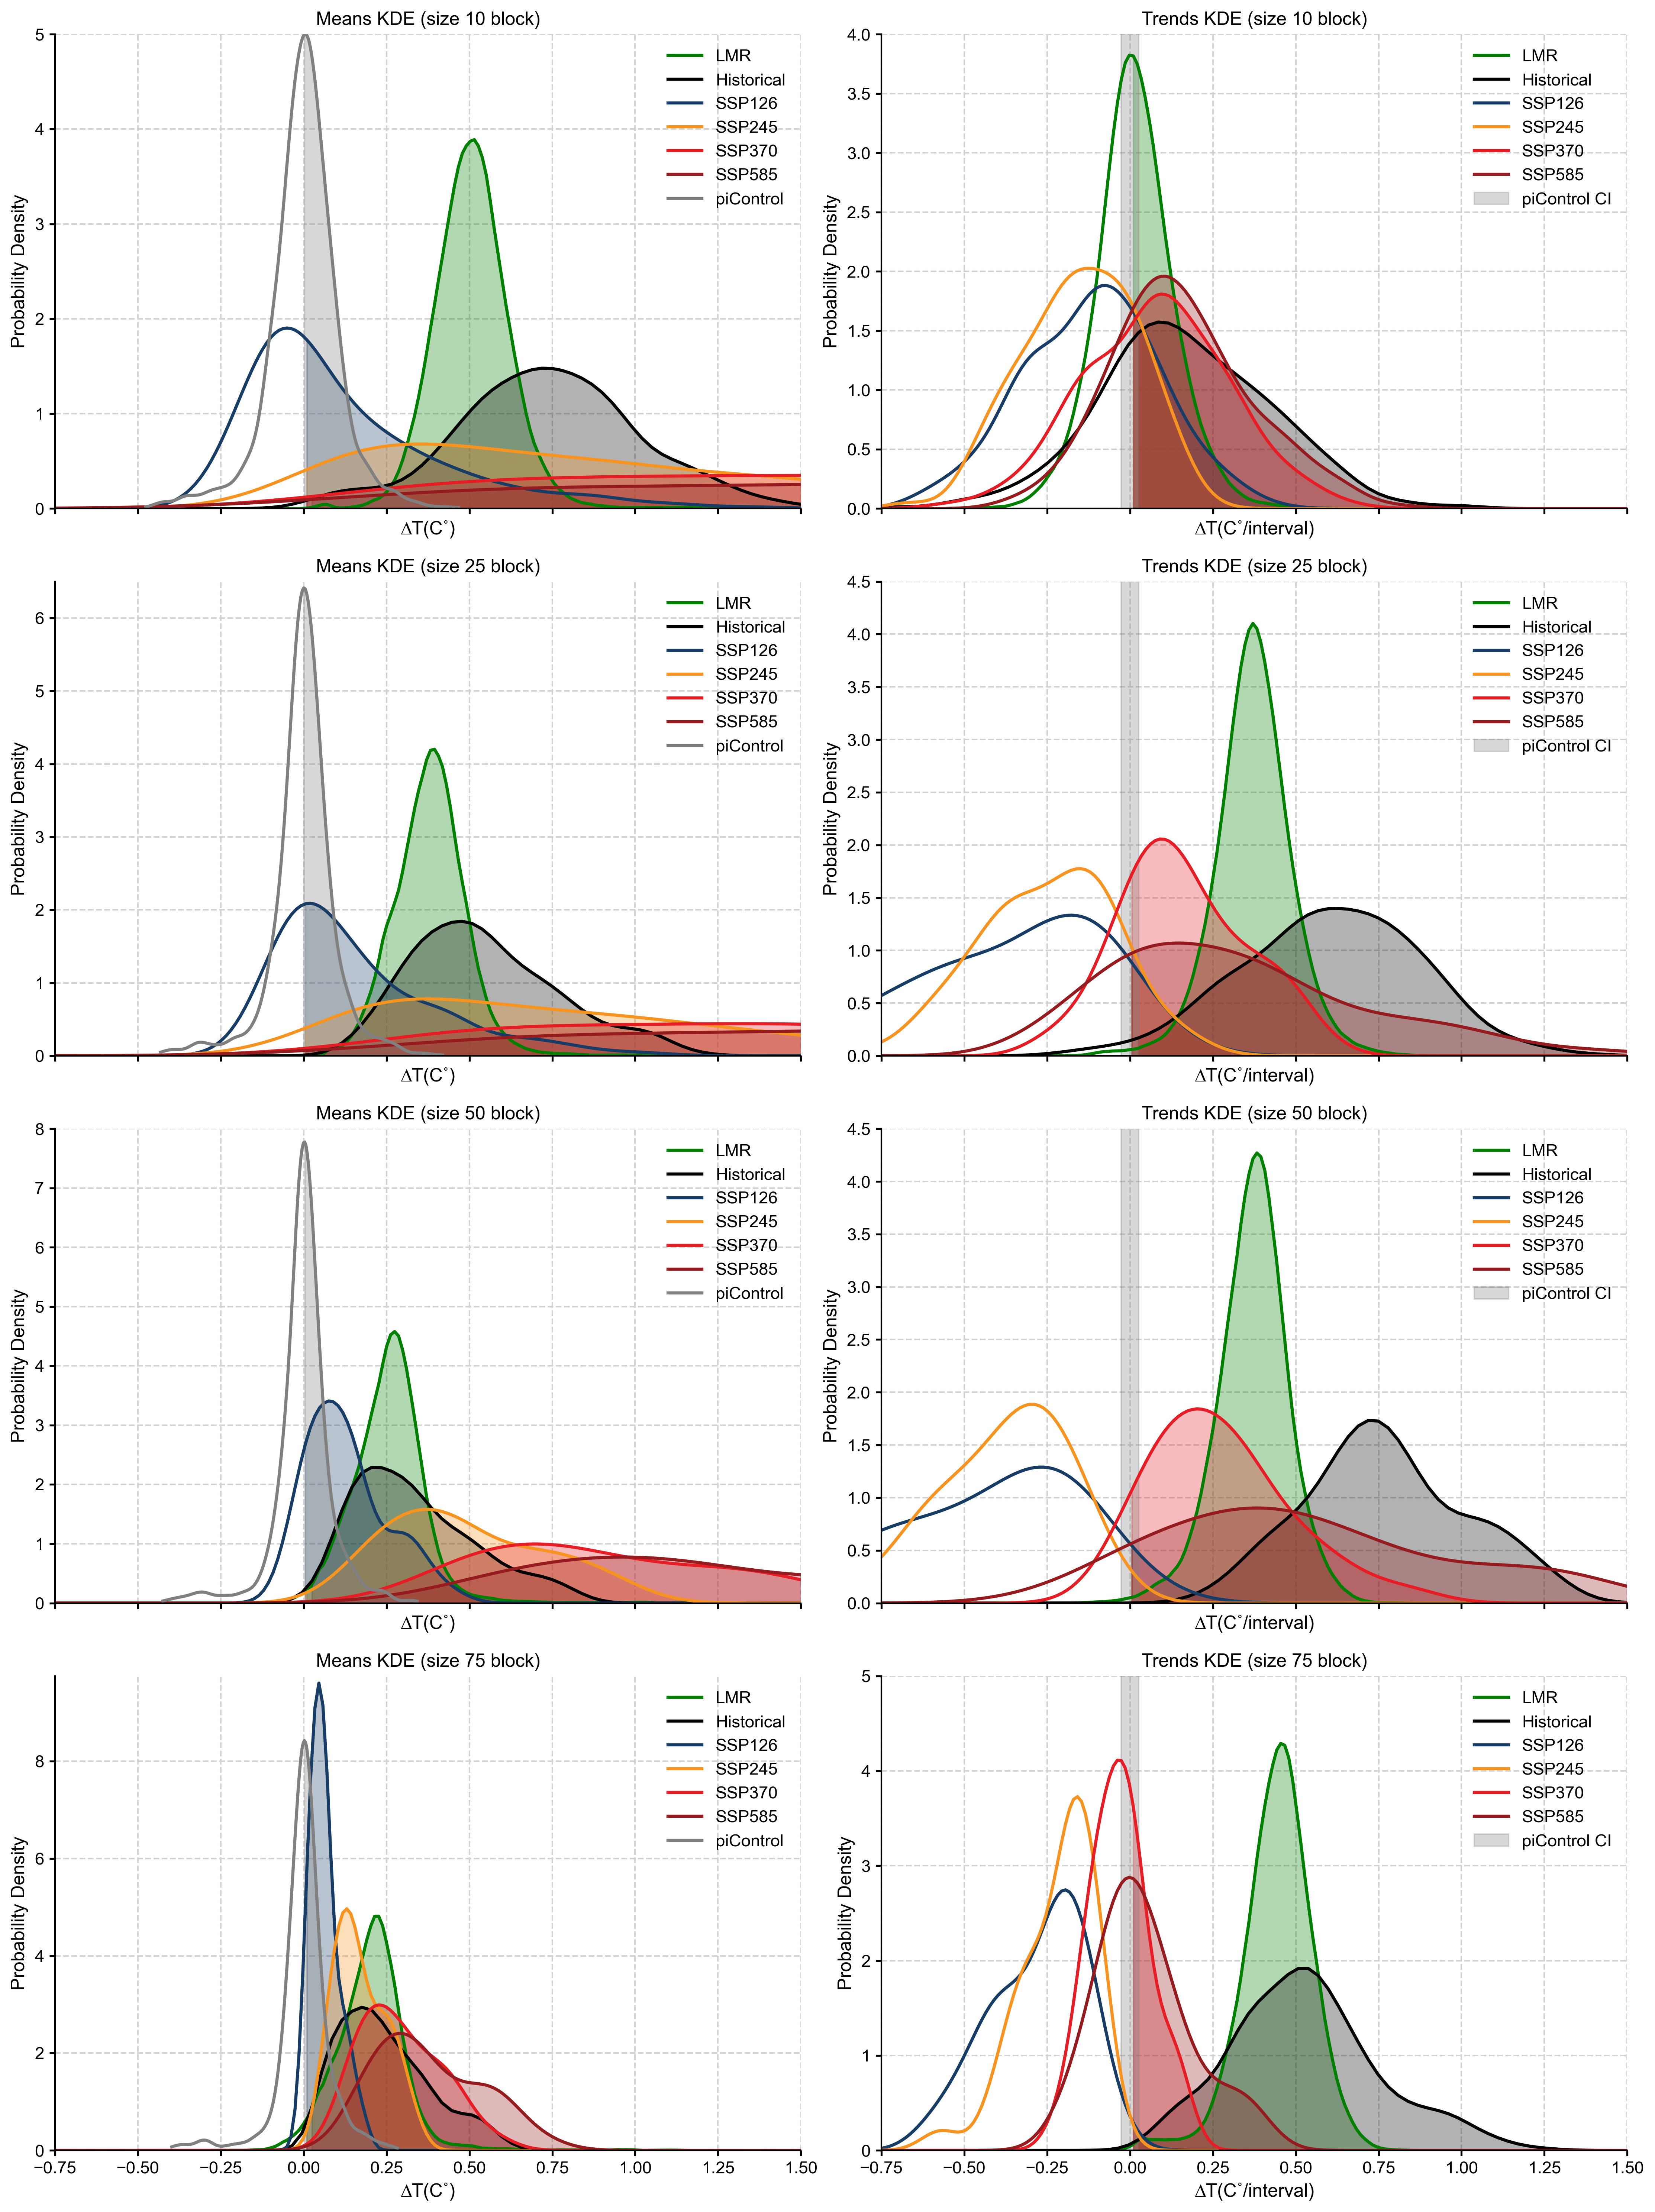

In [49]:
# ********** 10 BLOCK **********

# Create a figure with two subplots (1 row, 2 columns) and share the y-axis
fig, ax = plt.subplots(nrows=4, ncols=2, sharey=False, sharex=True, figsize=(15, 20))

# Plot the 'mean' KDE on the first subplot (ax[0])
lmr_trends_10.plot_trend_mean_kde(ax=ax[0][0], label = 'LMR', color = 'green', tag = 'mean')
hist_trends_10.plot_trend_mean_kde(ax=ax[0][0], label='Historical', color='black', tag='mean')
ssp126_trends_10.plot_trend_mean_kde(ax=ax[0][0], label='SSP126', color= ssp126C, tag='mean')
ssp245_trends_10.plot_trend_mean_kde(ax=ax[0][0], label='SSP245', color= ssp245C, tag='mean')
ssp370_trends_10.plot_trend_mean_kde(ax=ax[0][0], label='SSP370', color= ssp370C, tag='mean')
ssp585_trends_10.plot_trend_mean_kde(ax=ax[0][0], label='SSP585', color= ssp585C, tag='mean')
ax[0][0].plot(picon_means_trends_10[0][0], picon_means_trends_10[0][1], color = 'grey', label='piControl')

#setting up condition to plot piControl shading from when x>0
x = picon_means_trends_10[0][0]
y = picon_means_trends_10[0][1]
x_indices = np.where(x > 0)[0]

# Shade the area between the curve and the x-axis for x > 0
ax[0][0].fill_between(x[x_indices], y[x_indices], 0, color='grey', alpha=0.3) #shading effects

ax[0][0].set_xlabel('∆T(C˚)')
ax[0][0].set_title('Means KDE (size 10 block)')
ax[0][0].legend()

ax[0][0].set_xlim(-0.5, 5)
ax[0][0].set_ylim(0, 5)


# Plot the 'trend' KDE on the second subplot (ax[1])
lmr_trends_10.plot_trend_mean_kde(ax=ax[0][1], label = 'LMR', color = 'green', tag = 'trend')
hist_trends_10.plot_trend_mean_kde(ax=ax[0][1], label='Historical', color='black', hide_ylabel=True, tag='trend')
ssp126_trends_10.plot_trend_mean_kde(ax=ax[0][1], label='SSP126', hide_ylabel=True, color= ssp126C,  tag='trend')
ssp245_trends_10.plot_trend_mean_kde(ax=ax[0][1], label='SSP245', hide_ylabel=True, color= ssp245C, tag='trend')
ssp370_trends_10.plot_trend_mean_kde(ax=ax[0][1], label='SSP370', hide_ylabel=True, color= ssp370C, tag='trend')
ssp585_trends_10.plot_trend_mean_kde(ax=ax[0][1], label='SSP585', hide_ylabel=True, color= ssp585C, tag='trend')

# Calculate the central 95% confidence interval for piControl trends
lower_bounds = []
upper_bounds = []
for key in pi_files.keys():
    trends_data = picon_10[key]['trends'][:, 0]
    lower_bound = np.percentile(trends_data, 2.5)
    upper_bound = np.percentile(trends_data, 97.5)
    lower_bounds.append(lower_bound)
    upper_bounds.append(upper_bound)

mean_lower_bound = np.mean(lower_bounds)
mean_upper_bound = np.mean(upper_bounds)

# Plot the 95% confidence interval using fill_betweenx
y_values = np.arange(len(pi_files))
ax[0][1].fill_betweenx(y_values, mean_lower_bound, mean_upper_bound, color='grey', alpha=0.3, label='piControl CI')

ax[0][1].set_xlabel('∆T(C˚/interval)')
ax[0][1].set_title('Trends KDE (size 10 block)')
ax[0][1].legend()

ax[0][1].set_xlim(-0.75, 1)
ax[0][1].set_ylim(0, 4)

# ********** 25 BLOCK **********

# Plot the 'mean' KDE on the first subplot (ax[0])
lmr_trends_25.plot_trend_mean_kde(ax=ax[1][0], label = 'LMR', color = 'green', tag = 'mean')
hist_trends_25.plot_trend_mean_kde(ax=ax[1][0], label='Historical', color='black', tag='mean')
ssp126_trends_25.plot_trend_mean_kde(ax=ax[1][0], label='SSP126', color= ssp126C, tag='mean')
ssp245_trends_25.plot_trend_mean_kde(ax=ax[1][0], label='SSP245', color= ssp245C, tag='mean')
ssp370_trends_25.plot_trend_mean_kde(ax=ax[1][0], label='SSP370', color= ssp370C, tag='mean')
ssp585_trends_25.plot_trend_mean_kde(ax=ax[1][0], label='SSP585', color= ssp585C, tag='mean')
ax[1][0].plot(picon_means_trends_25[0][0], picon_means_trends_25[0][1], color = 'grey', label='piControl')

#setting up condition to plot piControl shading from when x>0
x = picon_means_trends_25[0][0]
y = picon_means_trends_25[0][1]
x_indices = np.where(x > 0)[0]

# Shade the area between the curve and the x-axis for x > 0
ax[1][0].fill_between(x[x_indices], y[x_indices], 0, color='grey', alpha=0.3) #shading effects

ax[1][0].set_xlabel('∆T(C˚)')
ax[1][0].set_title('Means KDE (size 25 block)')
ax[1][0].legend()

ax[1][0].set_xlim(-0.5, 5)
ax[1][0].set_ylim(0, 6.5)


# Plot the 'trend' KDE on the second subplot (ax[1])
lmr_trends_25.plot_trend_mean_kde(ax=ax[1][1], label = 'LMR', color = 'green', tag = 'trend')
hist_trends_25.plot_trend_mean_kde(ax=ax[1][1], label='Historical', color='black', hide_ylabel=True, tag='trend')
ssp126_trends_25.plot_trend_mean_kde(ax=ax[1][1], label='SSP126', hide_ylabel=True, color= ssp126C,  tag='trend')
ssp245_trends_25.plot_trend_mean_kde(ax=ax[1][1], label='SSP245', hide_ylabel=True, color= ssp245C, tag='trend')
ssp370_trends_25.plot_trend_mean_kde(ax=ax[1][1], label='SSP370', hide_ylabel=True, color= ssp370C, tag='trend')
ssp585_trends_25.plot_trend_mean_kde(ax=ax[1][1], label='SSP585', hide_ylabel=True, color= ssp585C, tag='trend')

# Plot the 95% confidence interval using fill_betweenx
ax[1][1].fill_betweenx(y_values, mean_lower_bound, mean_upper_bound, color='grey', alpha=0.3, label='piControl CI')


ax[1][1].set_xlabel('∆T(C˚/interval)')
ax[1][1].set_title('Trends KDE (size 25 block)')
ax[1][1].legend()

ax[1][1].set_xlim(-1.5, 1.5)
ax[1][1].set_ylim(0, 4.5)


# ********** 50 BLOCK **********

# Plot the 'mean' KDE on the first subplot (ax[0])
lmr_trends_50.plot_trend_mean_kde(ax=ax[2][0], label = 'LMR', color = 'green', tag = 'mean')
hist_trends_50.plot_trend_mean_kde(ax=ax[2][0], label='Historical', color='black', tag='mean')
ssp126_trends_50.plot_trend_mean_kde(ax=ax[2][0], label='SSP126', color= ssp126C, tag='mean')
ssp245_trends_50.plot_trend_mean_kde(ax=ax[2][0], label='SSP245', color= ssp245C, tag='mean')
ssp370_trends_50.plot_trend_mean_kde(ax=ax[2][0], label='SSP370', color= ssp370C, tag='mean')
ssp585_trends_50.plot_trend_mean_kde(ax=ax[2][0], label='SSP585', color= ssp585C, tag='mean')
ax[2][0].plot(picon_means_trends_50[0][0], picon_means_trends_50[0][1], color = 'grey', label='piControl')

#setting up condition to plot piControl shading from when x>0
x = picon_means_trends_50[0][0]
y = picon_means_trends_50[0][1]
x_indices = np.where(x > 0)[0]

# Shade the area between the curve and the x-axis for x > 0
ax[2][0].fill_between(x[x_indices], y[x_indices], 0, color='grey', alpha=0.3) #shading effects

ax[2][0].set_xlabel('∆T(C˚)')
ax[2][0].set_title('Means KDE (size 50 block)')
ax[2][0].legend()

ax[2][0].set_xlim(-0.5, 3)
ax[2][0].set_ylim(0, 8)


# Plot the 'trend' KDE on the second subplot (ax[1])
lmr_trends_50.plot_trend_mean_kde(ax=ax[2][1], label = 'LMR', color = 'green', tag = 'trend')
hist_trends_50.plot_trend_mean_kde(ax=ax[2][1], label='Historical', color='black', hide_ylabel=True, tag='trend')
ssp126_trends_50.plot_trend_mean_kde(ax=ax[2][1], label='SSP126', hide_ylabel=True, color= ssp126C,  tag='trend')
ssp245_trends_50.plot_trend_mean_kde(ax=ax[2][1], label='SSP245', hide_ylabel=True, color= ssp245C, tag='trend')
ssp370_trends_50.plot_trend_mean_kde(ax=ax[2][1], label='SSP370', hide_ylabel=True, color= ssp370C, tag='trend')
ssp585_trends_50.plot_trend_mean_kde(ax=ax[2][1], label='SSP585', hide_ylabel=True, color= ssp585C, tag='trend')

# Plot the 95% confidence interval using fill_betweenx
ax[2][1].fill_betweenx(y_values, mean_lower_bound, mean_upper_bound, color='grey', alpha=0.3, label='piControl CI')


ax[2][1].set_xlabel('∆T(C˚/interval)')
ax[2][1].set_title('Trends KDE (size 50 block)')
ax[2][1].legend()

ax[2][1].set_xlim(-1.5, 1.5)
ax[2][1].set_ylim(0, 4.5)


# ********** 75 BLOCK **********

# Plot the 'mean' KDE on the first subplot (ax[0])
lmr_trends_75.plot_trend_mean_kde(ax=ax[3][0], label = 'LMR', color = 'green', tag = 'mean')
hist_trends_75.plot_trend_mean_kde(ax=ax[3][0], label='Historical', color='black', tag='mean')
ssp126_trends_75.plot_trend_mean_kde(ax=ax[3][0], label='SSP126', color= ssp126C, tag='mean')
ssp245_trends_75.plot_trend_mean_kde(ax=ax[3][0], label='SSP245', color= ssp245C, tag='mean')
ssp370_trends_75.plot_trend_mean_kde(ax=ax[3][0], label='SSP370', color= ssp370C, tag='mean')
ssp585_trends_75.plot_trend_mean_kde(ax=ax[3][0], label='SSP585', color= ssp585C, tag='mean')
ax[3][0].plot(picon_means_trends_75[0][0], picon_means_trends_75[0][1], color = 'grey', label='piControl')

#setting up condition to plot piControl shading from when x>0
x = picon_means_trends_75[0][0]
y = picon_means_trends_75[0][1]
x_indices = np.where(x > 0)[0]

# Shade the area between the curve and the x-axis for x > 0
ax[3][0].fill_between(x[x_indices], y[x_indices], 0, color='grey', alpha=0.3) #shading effects

ax[3][0].set_xlabel('∆T(C˚)')
ax[3][0].set_title('Means KDE (size 75 block)')
ax[3][0].legend()

ax[3][0].set_xlim(-0.5, 1)
ax[3][0].set_ylim(0, 9.75)


# Plot the 'trend' KDE on the second subplot (ax[1])
lmr_trends_75.plot_trend_mean_kde(ax=ax[3][1], label = 'LMR', color = 'green', tag = 'trend')
hist_trends_75.plot_trend_mean_kde(ax=ax[3][1], label='Historical', color='black', hide_ylabel=True, tag='trend')
ssp126_trends_75.plot_trend_mean_kde(ax=ax[3][1], label='SSP126', hide_ylabel=True, color= ssp126C,  tag='trend')
ssp245_trends_75.plot_trend_mean_kde(ax=ax[3][1], label='SSP245', hide_ylabel=True, color= ssp245C, tag='trend')
ssp370_trends_75.plot_trend_mean_kde(ax=ax[3][1], label='SSP370', hide_ylabel=True, color= ssp370C, tag='trend')
ssp585_trends_75.plot_trend_mean_kde(ax=ax[3][1], label='SSP585', hide_ylabel=True, color= ssp585C, tag='trend')

# Plot the 95% confidence interval using fill_betweenx
ax[3][1].fill_betweenx(y_values, mean_lower_bound, mean_upper_bound, color='grey', alpha=0.3, label='piControl CI')

ax[3][1].set_xlabel('∆T(C˚/interval)')
ax[3][1].set_title('Trends KDE (size 75 block)')
ax[3][1].legend()

ax[3][1].set_xlim(-0.75, 1.5)
ax[3][1].set_ylim(0, 5)


# Adjust layout to prevent overlapping of subplots
plt.tight_layout()

plt.rcParams['figure.dpi'] = 300

# ******************* Save the figure as an image *******************
#plt.savefig('trends_plots.png')                 
# *******************************************************************
# Display the subplots

plt.show()